## Compare embeddings of title aggregates and mean embeddings of titles

In [32]:
from imbed_data_prep.hcp import Hcp3Dacc

dacc = Hcp3Dacc()

## Get the three kinds of embeddings data

In [33]:
title_embeddings = dacc.embeddings_hcp2  # took 9s

print(f"{title_embeddings.shape}")
title_embeddings.head(1)

(352508,)


id
245658    [0.013564770109951496, 0.010467253625392914, -...
Name: embedding, dtype: object

In [34]:
def _aggregate_titles_embeddings(dacc):
    aggregate_titles_embeddings = dacc.aggregate_titles_embeddings  # took 7s
    aggregate_titles_embeddings = aggregate_titles_embeddings.set_index('id', drop=True)
    aggregate_titles_embeddings = aggregate_titles_embeddings['vector']
    return aggregate_titles_embeddings

aggregate_titles_embeddings = _aggregate_titles_embeddings(dacc)
print(f"{aggregate_titles_embeddings.shape}")
aggregate_titles_embeddings.head(1)


(340855,)


id
245658    [-0.015486514195799828, 0.01210845448076725, 0...
Name: vector, dtype: object

In [ ]:
from imbed_data_prep.embeddings_of_aggregations import fuzzy_induced_graph

# filtered_citations_graph = fuzzy_induced_graph(dacc)

citation_graph = dict(
    fuzzy_induced_graph(
        dacc.citations_of, set(dacc.aggregate_titles_embeddings['id']), min_proportion=1
    )
)
print(f"{len(dacc.citations_of)=}")
print(f"After keeping only items for which we have titles for both citing and cited, ")
print(f"we're left with {len(citation_graph)}")

len(dacc.citations_of)=308135
After keeping only items for which we have titles for both citing and cited, 
we're left with 229879


In [51]:
citing_id, cited_ids = next(iter(citation_graph.items()))

citing_id, cited_ids

(245658, [2138790588, 2013150886])

## compare similarities between the three methods

In [ ]:
from imbed import cosine_similarity
# from imbed.util import norm
import numpy as np
# normalized means (where we first normalize each vector before taking the mean)
# Normalization is done by dividing each vector by its norm
# This is in order to (perhaps) better reflect the cosine similarity between the vectors
# Note: What about `vectors.mean(axis=0) / np.linalg.norm(vectors.mean(axis=0))`?
def normalized_vector_mean(vectors: np.ndarray):
    """
    Normalize the vactors (so their norm is 1) and then take the mean.
    This is in order to (perhaps) better reflect the cosine similarity between the vectors
    Note: What about `vectors.mean(axis=0) / np.linalg.norm(vectors.mean(axis=0))`?
    """
    if isinstance(vectors, pd.Series):
        vectors = np.array(vectors.to_list())
    return (vectors / np.linalg.norm(vectors, axis=1)[:, None]).mean(axis=0)


def embeddings_stats(citation_graph):
    for i, (citing_id, cited_ids) in enumerate(citation_graph.items()):
        if (
            citing_id in aggregate_titles_embeddings
        ):  # only process if we have aggregated titles embeddings
            # filter out cited_ids that are not in title_embeddings
            cited_ids_we_have = sorted(filter(lambda x: x in title_embeddings.index, cited_ids))
            # getting the three types of embeddings
            citing_embedding = title_embeddings.loc[citing_id]
            _cited_ids_embeddings = title_embeddings.loc[cited_ids_we_have]
            mean_cited_embedding = _cited_ids_embeddings.mean()
            means_of_normalized = normalized_vector_mean(_cited_ids_embeddings)
            aggregated_citing_and_cited_embedding = aggregate_titles_embeddings[
                citing_id
            ]
            # yield the stats
            yield dict(
                citing_id=citing_id,
                cited_ids_we_have=cited_ids_we_have,
                n_cited_w_titles=len(cited_ids),
                citing_vs_mean_cited_simularity=cosine_similarity(
                    citing_embedding, mean_cited_embedding
                ),
                means_of_normalized=cosine_similarity(
                    citing_embedding, means_of_normalized
                ),
                citing_vs_aggregated_simularity=cosine_similarity(
                    citing_embedding, aggregated_citing_and_cited_embedding
                ),
                mean_vs_aggregated_simularity=cosine_similarity(
                    mean_cited_embedding, aggregated_citing_and_cited_embedding
                ),
            )


from itertools import islice
import pandas as pd

# stats = pd.DataFrame(islice(embeddings_stats(), 10_0)).set_index('citing_id', drop=False)
stats = pd.DataFrame(embeddings_stats(citation_graph)).set_index('citing_id', drop=False)  # took ~1m

In [70]:
print(f"{stats.shape=}")
stats.head(3)

stats.shape=(229879, 7)


,citing_id,cited_ids_we_have,n_cited_w_titles,citing_vs_mean_cited_simularity,means_of_normalized,citing_vs_aggregated_simularity,mean_vs_aggregated_simularity
citing_id,,,,,,,
245658,245658,"[2013150886, 2138790588]",2,0.423786,0.423786,0.810706,0.505194
718838,718838,"[1604916109, 1965439999, 1969852349, 197786947...",29,0.652895,0.652895,0.594726,0.760848
898828,898828,"[2025976960, 2172013173]",2,0.555090,0.555090,0.616572,0.688894


In [71]:
def proportion_of_times_agg_is_closer(stats):
    n_times_agg_is_closer = sum(
        stats['citing_vs_aggregated_simularity'] > stats['citing_vs_mean_cited_simularity']
    )
    return n_times_agg_is_closer / len(stats)

print(
    f"Proportion of times the aggregation method is closer than the mean method: " 
    f"{proportion_of_times_agg_is_closer(stats) * 100:.0f}%"
)


Proportion of times the aggregation method is closer than the mean method: 66%


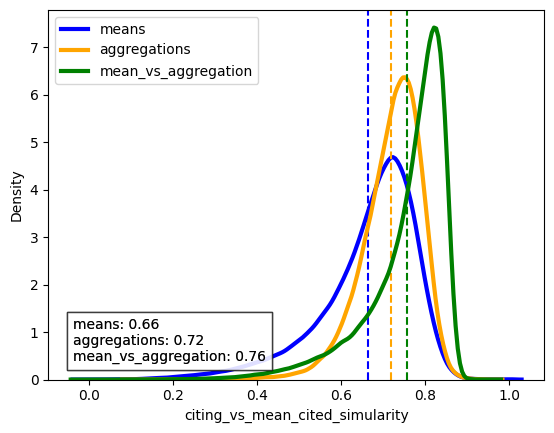

In [118]:
from oplot import density_distribution

# Apply the function to the current case
data_dict = {
    'means': stats['citing_vs_mean_cited_simularity'],
    # 'normalized_means': stats['means_of_normalized'],
    'aggregations': stats['citing_vs_aggregated_simularity'],
    'mean_vs_aggregation': stats['mean_vs_aggregated_simularity'],
}
density_distribution(data_dict)

In [56]:
# Question: What is the average gain of the aggregated approach over the mean approach 
# when comparing simularity to title embedding?
aggregation_method_gain = (
    stats['citing_vs_aggregated_simularity'].mean() 
    / stats['citing_vs_mean_cited_simularity'].mean()
) * 100 - 100
print(f"The aggregated approach gains and average of {aggregation_method_gain:.2f}% \n"
      "over the mean approach when comparing simularity to title embedding")


The aggregated approach gains and average of 8.24% 
over the mean approach when comparing simularity to title embedding


## How much is the aggregated method sensitive to order?

Unlike some text vectorization techniques (e.g. TFIDF), in the transformer-based embeddings 
we used here, word order matters.
The order we aggregated the citations was arbitrary (just took the order in which they were listed), 
and it is not obvious what the best order would be. 
This will of course depend on the context. 
But one thing we can look into is how much the order actually effects the embeddings.

In [36]:
from imbed_data_prep.hcp import Hcp3Dacc
import math

dacc = Hcp3Dacc()

assert math.factorial(4) == 24
assert math.factorial(5) == 120
# ... so we'll choose 5 as the minimum citations for an article to be considered, 
# so that we can have at least unique 30 permutations for each
min_citations = 5
n_permutations = 30

# First, filter dacc.info_hcp2 to keep only rows with 'id' in embeddings_hcp2.index
filtered_info = dacc.info_hcp2[dacc.info_hcp2['id'].isin(dacc.embeddings_hcp2.index)]

# Now, create the dictionary directly from the filtered DataFrame
titles = filtered_info.set_index('id')['title'].to_dict()

# Make a citation graph, keeping only those for which we have titles for both citing and cited
citation_graph = dacc.citation_graph(min_proportion=1, ids_with_embeddings=set(titles), min_citations=min_citations)

print(f"{len(titles)=}")
print(f"After keeping only items for which we have titles for both citing and cited, ")
print(f"we're left with {len(citation_graph)}")

len(titles)=352508
After keeping only items for which we have titles for both citing and cited, 
we're left with 230018


In [37]:
from itertools import islice
from lkj import truncate_dict_values

dict_slice = lambda d, *args: dict(islice(d.items(), *args))

t = dict_slice(citation_graph, 0, 3)
truncate_dict_values(t, max_list_size=3)

{718838: [1994893189, 2158553737, 1604916109],
 831416: [2114205159, 2161774890, 1965693998],
 1769291: [2161984704, 2130907431, 2170131723]}

In [53]:
from imbed_data_prep.embeddings_of_aggregations import aggregated_embeddings_for_sample
from imbed import simple_embedding_vectorizer
from functools import partial
import oa

aggregated_embeddings = partial(
    aggregated_embeddings_for_sample,
    n_nodes = 1000,
    n_permutations = n_permutations,
    node_to_text = titles.get,
    aggregate_texts = "\n\n".join,
    text_to_embedding = None,
    max_permutations = n_permutations,
    seed = 0
)

text_to_embed = {
    (x['citing_id'], x['permutation_index'], x['n_cited']): x['aggregated_title'] for x in aggregated_embeddings(citation_graph)
}
len(text_to_embed)


30000

In [60]:
# from hubcap import repo_text_aggregate

# oa_repo_text = repo_text_aggregate('thorwhalen/oa')
# imbed_repo_text = repo_text_aggregate('thorwhalen/imbed')


In [ ]:
# from pathlib import Path

# Path('/Users/thorwhalen/Dropbox/_odata/ai_contexts/i2i/imbed.md').write_text(imbed_repo_text)

112697

In [ ]:
import oa

354165

In [ ]:

# Then, compute spread statistics and compute the cosine similarity of the citing title with the aggregated title.
# (normalized) 
# mean of the cosine similarities of the citing title (embedding) 
# with the embedding of the cited titles (embeddings) for each permutation.

## How much is the aggregated method sensitive to how we aggregate?

Here we aggregated by contatenating citing title and cited titles, 
using some joining strings (parametrizable).
- How much would using different joining strings affect our embeddings?
- Would a different kind of aggregation improve the embeddings (e.g. aggregating as prompt mentioning the nature of the titles (citing and cited))?

## Measuring the actual objective

Here we just compared different methods of getting an embedding for an article based on 
it's title as well as the titles of its citations. 
But we are limited and answering the question "which is better?" Without a clear measured objective.
We'll look into that more here. 

Let's say we want the vector to best capture the ideas within the text. 
Fair enough; but how do we measure how well it does?
We compared the vectors of the citations' titles mean and the aggregation methods to 
the vector for the title itself. 

On the other hand, we didn't really address the question of how well the title's embedding 
itself represents the contents of the article. 
This probably varies widely, depending on how many different topics the content contains, 
how well the title was crafted, when the embedding model was made, etc.

For example, how well does the title 
"Attention is all you need." represent the siminal paper on transformers? 
Initially, the embedded representation of ‘Attention is All You Need’ captures only the general 
meanings of focus and necessity. 
But, as the article garners more attention (pun engineered), 
as the article’s influence grows and the phrase becomes tied to the transformative power of the model it introduced, future embeddings may begin to reflect its deeper technical and cultural significance.

Regardless, in this section we will explore a few use cases, their objectives, and how one can 
measure their objectives so as to answer the question "which (title-based) embedding is better"?

We will take search as our overarching use case. 
That is, an actor (user or system) wishes to find abstracts, articles, or parts of articles, that are 
relevant to a query. 
In the case of abstracts, we can take the embedding of the abstract as the thing that we're 
trying to approximate through our title based embeddings. 
This does represent the real process of a user searching for articles. 
When faced with the results of their search, they will usually consider the title 
(so in that case, title does represent the searched "truth"), and if satisfactory, 
will consider the abstract. Whether or not the abstract represents the contents of the article
is another question, which we have no control over in this context 
(though are analysis here can lead to tools to give abstract-writers some indication of 
how well their abstract represents their article's content).

When we move further to considering the actual content of the article, we are forced to 
consider the problems of segmentation and multi-modality. 
The entirety of an articles' content will not usually not fit in an embeddings' maximum input size. 
Several techniques can be used here. 
One of them we'd like to mention, because it avoids segmentation, is to use an LLM 
large enough to fit the whole article, asking it to write a
small-enough-to-fit-into-the-embeddings-input-size abstract. 

Another common method is to segment the content. 
So now that we have not one, but several bits of text to be embedded, we One of the problems with search is that the items that are searched may not be represented as 
a singular thing but a set of multiple things -- for example, single versus multiple topics. 
So now, we are faced with the problem of measuring the similarity between one vector and a set of other vectors.



3

## Misc mean vs aggregation stuff

In [113]:
from imbed_data_prep.embeddings_of_aggregations import test_all_permutation_tools

test_all_permutation_tools()

In [114]:
from imbed_data_prep.hcp import Hcp3Dacc

dacc = Hcp3Dacc()

In [ ]:
df = dacc.titles_aggregate_sr()  # took 55s